### Introducción

La prueba consta de tres ejercicios generales. El formato de entrega es un `jupyter notebook` con las actividades desarrolladas y una leve descripción de los pasos utilizados para resolver las preguntas.

## Ejercicio 1

El primero es un ejercicio de SQL, puede ser resuelto utilizando diferentes frameworks para manipular tablas, tales como: `SQL`, `pandas` , `polars`, incluso ciclos for en caso de ser necesario. Las preguntas de la actividad se detallan a continuación:

A partir del archivo `datos.parquet` ó `datos.csv` determine los siguientes campos:
- Determine la cantidad total de informes validados enviados por cada `Fuente`.
- Determine la fuente con mayor cantidad de `informes totales` en estado `cumplen` enviados.

- Determine el la `fecha` del último informe validado enviado anteriormente por la fuente.
- - Para esto considere que un informe es valido si es `Validado` o `Parcialmente Validado` y las caracteristicas del informe `Cumplen` con el estandar establecido.
- - De igual manera los informes deben respetar la `clasificacion` existente.
- - El resultado debe ser una columna adicional con el nombre `fecha_ultimo_muestreo_validado`, para los casos donde no exista un informe asociado rellene con `nulos`.

#### Descripción de la data
Una breve descripción de la data se presenta a continuación:
- `fuente_id` : Representa el ID asociado a cada fuente, llave externa.
- `clasificacion` : Una clasificación interna asociada a cada combustible. Una fuente puede tener más de una clasificación, esto representa que tiene más de un componente asociado.
- `fecha_envio` : Fecha de envío de los informes
- `estado_informe` : Estado del informe luego de ser recepcionado.
- `envio_id` : Llave externa asociada a los registros en el sistema, una misma `fuente` puede tener más de un valor de `envio_id`.
- `caracteristicas_informe` : Columna que específica si un informe cumple o no las condiciones para pasar a la siguiente etapa de análisis.


# Ejercicio 1 — KPI de informes validados y trazabilidad por fuente  

## Objetivo  
Construir indicadores confiables para monitorear el estado de los **informes** y su **trazabilidad** por **fuente**, respondiendo:  
1. ¿Cuántos informes **válidos** tiene cada fuente?  
2. ¿Qué fuente tiene **más informes que “cumplen”**?  
3. ¿Cuál fue la **última fecha de muestreo validado** por fuente?

---

## Definiciones (alineadas a negocio)  
- **Informe válido**: `estado_informe ∈ {Validado, Validado parcialmente}` **y** `caracteristicas_informe` contiene “cumple” (insensible a mayúsculas).  
- **Cumple**: detección textual de la palabra “cumple” en `caracteristicas_informe` (insensible a mayúsculas; tolera nulos).  

---

## Supuestos de columnas  
- `fuente_id`: identificador único de la fuente.  
- `estado_informe`: estado del informe (ej: Validado, Validado parcialmente, Rechazado).  
- `caracteristicas_informe`: texto con condiciones de cumplimiento.  
- `fecha_envio`: fecha/hora del informe.  

---

## Criterios de calidad de datos  
- Conversión robusta de `fecha_envio` a formato datetime.  
- Manejo de nulos en columnas de texto.  
- Insensibilidad a mayúsculas en estados y búsquedas textuales.  
- Validación de columnas mínimas antes de ejecutar el análisis.  

---

## Entregables  
- **validados_por_fuente**: total de informes válidos por fuente.  
- **fuente_top_cumplen**: fuente con mayor volumen de informes con “cumple”.  
- **ultimo_muestreo_validado**: máxima fecha de muestreo validado por fuente.  
- **resumen_por_fuente**: tabla consolidada que integra todos los indicadores.  

---

## Conclusiones esperadas  
- Identificar las fuentes con mayor volumen de informes válidos.  
- Detectar la fuente con mejor nivel de cumplimiento en informes enviados.  
- Obtener trazabilidad temporal del último muestreo validado por fuente.  
- Generar una vista consolidada que sirva como base para dashboards o reportes de gestión ambiental.  



In [30]:
#Importamos las librerias necesarias para el ejercicio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
#ruta csv
ruta = '/content/datos_prueba.csv'
df = pd.read_csv(ruta)
df

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
0,ID-8443,Principal,2024-03-20T13:02:24.037000,Con observaciones,7763,No cumple
1,ID-8443,Secundario,2024-03-20T12:58:40.683000,Con observaciones,7202,No cumple
2,ID-374,Principal,2023-10-31T12:26:39.703000,Con observaciones,8796,No cumple
3,ID-377,Principal,2024-04-30T09:07:07.917000,Con observaciones,11882,No cumple
4,ID-377,Principal,2024-04-29T19:17:20.667000,Con observaciones,11909,Cumple
...,...,...,...,...,...,...
4777,ID-2255,Secundario,2023-01-16T14:30:07.347000,Validado,4888,Cumple
4778,ID-19719,Secundario,2023-11-23T17:09:51.710000,Validado,7634,Cumple
4779,ID-19719,Secundario,2023-11-23T17:21:04.073000,Validado,9049,Cumple
4780,ID-5246,Secundario,2023-11-23T17:13:51.153000,Validado,9047,Cumple


---
# Analisis Exploratio, queremos identificar tipos de datos, valos nulos, que informacion se encuentra en el dataframe.

---

In [32]:
df.columns

Index(['fuente_id', 'clasificacion', 'fecha_envio', 'estado_informe',
       'envio_id', 'caracteristicas_informe'],
      dtype='object')

In [33]:
# importante para observar con que tipo de datos estamos trabajando
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   fuente_id                4782 non-null   object
 1   clasificacion            4782 non-null   object
 2   fecha_envio              4782 non-null   object
 3   estado_informe           4782 non-null   object
 4   envio_id                 4782 non-null   int64 
 5   caracteristicas_informe  4782 non-null   object
dtypes: int64(1), object(5)
memory usage: 224.3+ KB


In [34]:
# Convert 'fecha_envio' in the original DataFrame to datetime if not already done
df['fecha_envio'] = pd.to_datetime(df['fecha_envio'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fuente_id                4782 non-null   object        
 1   clasificacion            4782 non-null   object        
 2   fecha_envio              4782 non-null   datetime64[ns]
 3   estado_informe           4782 non-null   object        
 4   envio_id                 4782 non-null   int64         
 5   caracteristicas_informe  4782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 224.3+ KB


In [35]:
df.head(5)

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
0,ID-8443,Principal,2024-03-20 13:02:24.037,Con observaciones,7763,No cumple
1,ID-8443,Secundario,2024-03-20 12:58:40.683,Con observaciones,7202,No cumple
2,ID-374,Principal,2023-10-31 12:26:39.703,Con observaciones,8796,No cumple
3,ID-377,Principal,2024-04-30 09:07:07.917,Con observaciones,11882,No cumple
4,ID-377,Principal,2024-04-29 19:17:20.667,Con observaciones,11909,Cumple


In [36]:
# contaremos los valores NaN que se encuentren en cada columna del DataFrame
nan_counts = df.isnull().sum()

# Display the counts
display(nan_counts)

,0
fuente_id,0
clasificacion,0
fecha_envio,0
estado_informe,0
envio_id,0
caracteristicas_informe,0


In [37]:

print('Los valores unicos de la columna:clasificacion \n')
print(df['clasificacion'].unique(),'\n')


print('Los valores unicos de la columna: estado_informe \n')
print(df['estado_informe'].unique(),'\n')

print('Los valores unicos de la columna: caracteristicas_informe \n')
print(df['caracteristicas_informe'].unique(),'\n')



Los valores unicos de la columna:clasificacion 

['Principal' 'Secundario'] 

Los valores unicos de la columna: estado_informe 

['Con observaciones' 'Validado parcialmente' 'Validado' 'Rechazado'
 'Recepcionado'] 

Los valores unicos de la columna: caracteristicas_informe 

['No cumple' 'Cumple' 'N/D' 'No Evaluado'] 



In [38]:
df['estado_informe'].value_counts()

,count
estado_informe,
Validado,3294
Recepcionado,703
Rechazado,376
Con observaciones,335
Validado parcialmente,74


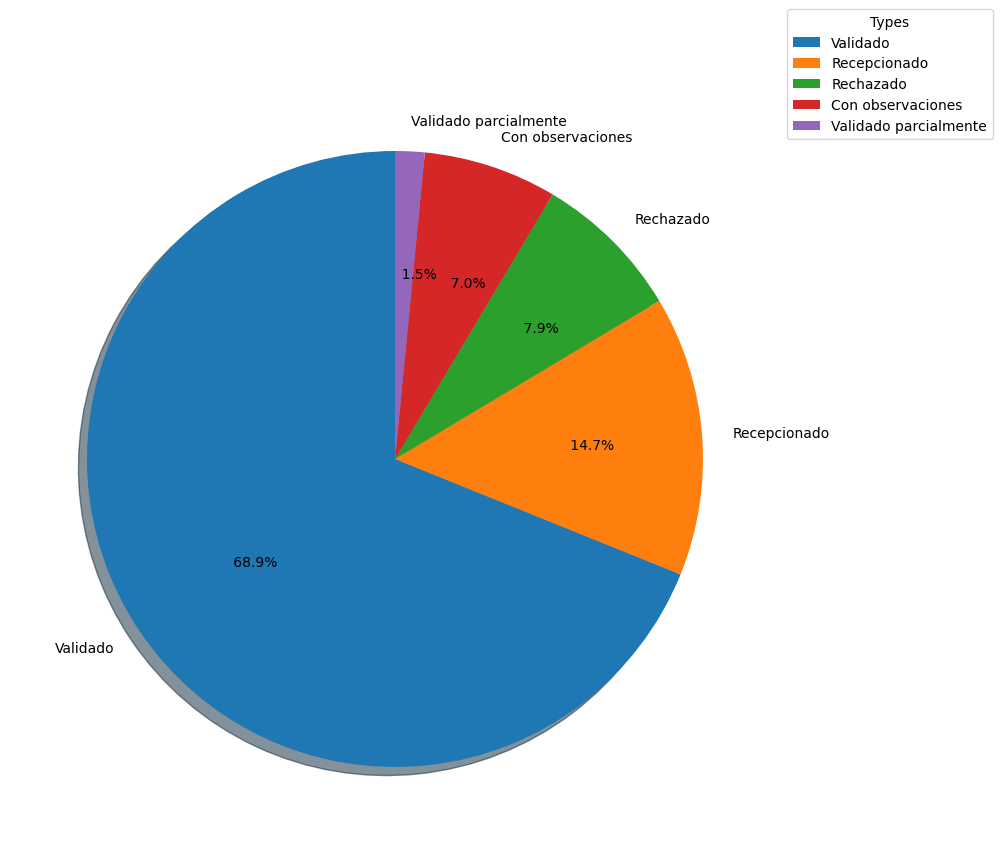

In [39]:
labels = df['estado_informe'].value_counts().index

plt.rcParams["figure.figsize"] = (10,10)
plt.pie(df['estado_informe'].value_counts(), labels =labels, autopct='%10.1f%%',
        shadow=True, startangle=90)

plt.legend(df['estado_informe'].value_counts().index ,title="Types",loc="center left", bbox_to_anchor=(1, .5, -1.5, 1))



## Objetivo 1: ¿Cuántos informes válidos tiene cada fuente?

In [40]:
def obtener_datos_validados(df):
  '''Dataframe llamado 'datos_validados' donde buscamos obtener la cantidad total de informes validados enviado por cada fuente ID'''
  dk = df.copy()
  datos_validados = dk[dk['estado_informe']=='Validado']
  #para obtener el total de informes validados por cada fuente
  Total_validados_ID = datos_validados['fuente_id'].value_counts()
  return datos_validados, Total_validados_ID


In [41]:
X = obtener_datos_validados(df)
datos_validados = X[0]
Total_validados_ID = X[1]

datos_validados


,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
28,ID-4477,Principal,2023-12-27 16:39:25.800,Validado,9594,Cumple
29,ID-4477,Principal,2024-01-17 11:40:16.273,Validado,9292,No cumple
30,ID-4477,Principal,2024-01-17 11:40:16.273,Validado,9292,Cumple
31,ID-4477,Principal,2024-01-17 11:42:05.193,Validado,9595,Cumple
32,ID-4477,Principal,2024-01-17 11:42:05.193,Validado,9595,No cumple
...,...,...,...,...,...,...
4777,ID-2255,Secundario,2023-01-16 14:30:07.347,Validado,4888,Cumple
4778,ID-19719,Secundario,2023-11-23 17:09:51.710,Validado,7634,Cumple
4779,ID-19719,Secundario,2023-11-23 17:21:04.073,Validado,9049,Cumple
4780,ID-5246,Secundario,2023-11-23 17:13:51.153,Validado,9047,Cumple


In [42]:
Total_validados_ID

,count
fuente_id,
ID-5658,14
ID-8802,13
ID-8906,13
ID-6565,10
ID-14279,9
...,...
ID-4379,1
ID-14212,1
ID-3549,1


In [43]:
print('total de ID con al menos 1 informe validado = ', len(Total_validados_ID))
print('El ID con mas archivos validados es',Total_validados_ID.index[1], 'con un total de =', Total_validados_ID.iloc[1], 'informes validados')

total de ID con al menos 1 informe validado =  1385
El ID con mas archivos validados es ID-8802 con un total de = 13 informes validados


In [44]:
datos_validados['caracteristicas_informe'].value_counts()

,count
caracteristicas_informe,
Cumple,2804
No cumple,489
No Evaluado,1


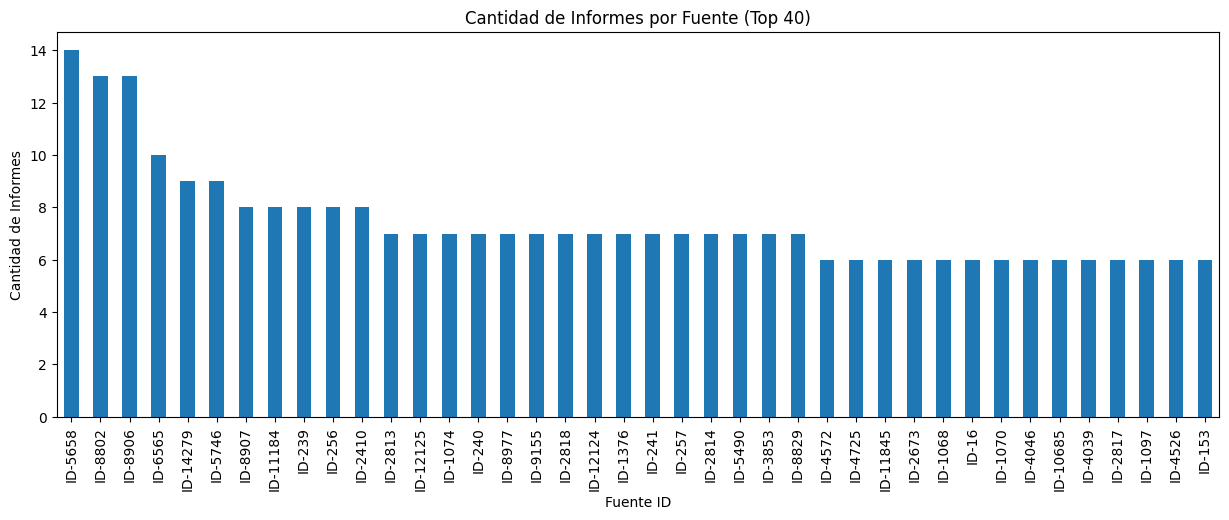

In [45]:
# Create a bar chart of the top 40 value counts of 'fuente_id'
datos_validados['fuente_id'].value_counts().head(40).plot(kind='bar', figsize=(15, 5))
plt.title('Cantidad de Informes por Fuente (Top 40)')
plt.xlabel('Fuente ID')
plt.ylabel('Cantidad de Informes')
plt.show()

## Solucion Objetivo 1:
-  Total de ID con al menos 1 informe validado =  1385
-  El ID con mas archivos validados es ID-8802 con un total de = 13 informes validados

## Objetivo 2: Determine la fuente con mayor cantidad de `informes totales` en estado `cumplen` enviados.

In [46]:
# Objetivo 2: Determine la fuente con mayor cantidad de `informes totales` en estado `cumplen` enviados.

In [47]:
def ID_MAX_cumple(df):

  dk = df.copy()
  Informes_finales = dk[dk['caracteristicas_informe']=='Cumple']
  #para obtener el total de informes validados por cada fuente
  Total_cumplen_ID = Informes_finales['fuente_id'].value_counts()
  ID_max = Informes_finales[Informes_finales['fuente_id']== Informes_finales['fuente_id'].value_counts().index[0]]

  return Informes_finales, ID_max

In [48]:
ID_cumple = ID_MAX_cumple(df)
Informe_cumplen = ID_cumple[0] #todos los ID que cumplen con la caracteristicas_informe =  'Cumple'
ID_max = ID_cumple[1] #dataframe del ID con mayor informes con la condicion caracteristicas_informe =  'Cumple'


In [49]:
Informe_cumplen

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
4,ID-377,Principal,2024-04-29 19:17:20.667,Con observaciones,11909,Cumple
7,ID-378,Principal,2024-04-29 19:19:02.063,Con observaciones,11932,Cumple
9,ID-375,Principal,2023-10-31 12:20:11.153,Con observaciones,8776,Cumple
10,ID-375,Principal,2023-10-31 12:21:38.577,Con observaciones,8779,Cumple
11,ID-375,Principal,2023-10-31 12:22:37.580,Con observaciones,8781,Cumple
...,...,...,...,...,...,...
4777,ID-2255,Secundario,2023-01-16 14:30:07.347,Validado,4888,Cumple
4778,ID-19719,Secundario,2023-11-23 17:09:51.710,Validado,7634,Cumple
4779,ID-19719,Secundario,2023-11-23 17:21:04.073,Validado,9049,Cumple
4780,ID-5246,Secundario,2023-11-23 17:13:51.153,Validado,9047,Cumple


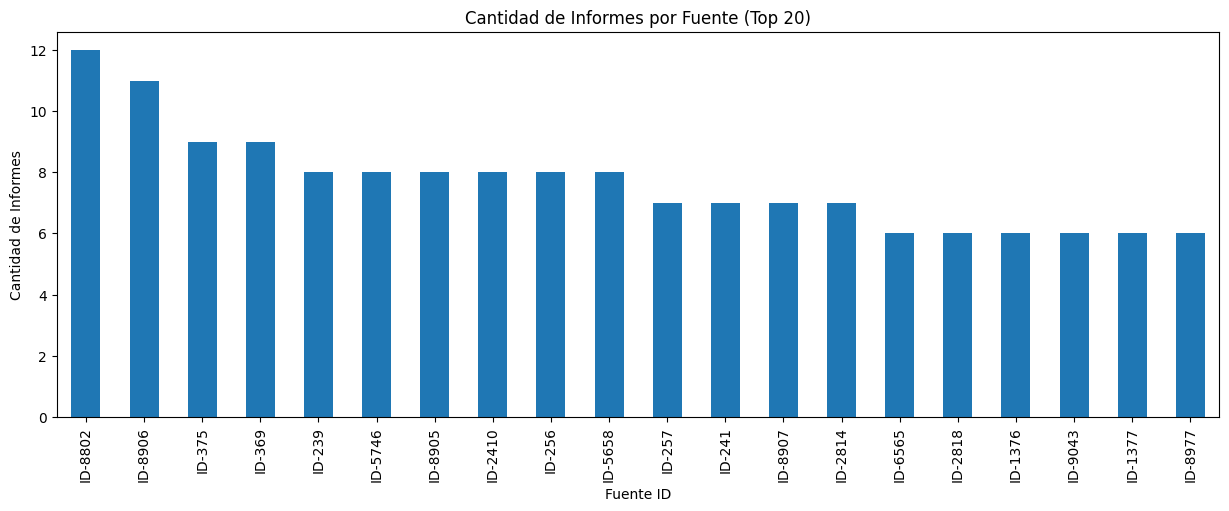

In [50]:
# Create a bar chart of the top 20 value counts of 'fuente_id'
Informe_cumplen['fuente_id'].value_counts().head(20).plot(kind='bar', figsize=(15, 5))
plt.title('Cantidad de Informes por Fuente (Top 20)')
plt.xlabel('Fuente ID')
plt.ylabel('Cantidad de Informes')
plt.show()

In [51]:
ID_max

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
1988,ID-8802,Principal,2023-06-29 15:57:50.683,Validado,4078,Cumple
1989,ID-8802,Principal,2023-07-03 10:54:20.703,Validado,7575,Cumple
1990,ID-8802,Principal,2023-06-29 16:33:47.357,Validado,4083,Cumple
1991,ID-8802,Principal,2023-06-29 17:31:47.820,Validado,4114,Cumple
1992,ID-8802,Principal,2023-06-29 17:56:37.473,Validado,4116,Cumple
1994,ID-8802,Principal,2023-08-23 11:11:54.870,Validado,7576,Cumple
1995,ID-8802,Secundario,2023-06-30 09:33:28.603,Validado,4069,Cumple
1996,ID-8802,Secundario,2023-06-30 09:40:58.283,Validado,4079,Cumple
1997,ID-8802,Secundario,2023-06-30 10:26:01.833,Validado,4108,Cumple
1998,ID-8802,Secundario,2023-06-30 10:32:25.873,Validado,4112,Cumple


In [52]:
# resultado: La fuente ID-8802 tiene 12 informes con la cartacteristica : Cumple . Siendo el Id con mayor cantidad de informes en este estado

## Solucion Objetivo 2:
- La fuente ID-8802 tiene 12 informes con la cartacteristica : Cumple . Siendo el Id con mayor cantidad de informes en este estado


# Objetivo  3:

 - Determine el la `fecha` del último informe validado enviado anteriormente por la fuente.
- - Para esto considere que un informe es valido si es `Validado` o `Parcialmente Validado` y las caracteristicas del informe `Cumplen` con el estandar establecido.
- - De igual manera los informes deben respetar la `clasificacion` existente.
- - El resultado debe ser una columna adicional con el nombre `fecha_ultimo_muestreo_validado`, para los casos donde no exista un informe asociado rellene con `nulos`.

In [53]:
def nuevos_datos(df):
    """
    Agrega 'fecha_ultimo_muestreo_validado' sin alterar el orden original del DataFrame.
    Considera válido si:
      - estado_informe ∈ {'Validado', 'Validado parcialmente'}
      - caracteristicas_informe == 'Cumple'
    Respeta la 'clasificacion' dentro de cada 'fuente_id'.
    """

    # 1) Validaciones y copia
    cols_necesarias = [
        'fuente_id', 'clasificacion', 'fecha_envio',
        'estado_informe', 'caracteristicas_informe'
    ]
    faltantes = [c for c in cols_necesarias if c not in df.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas en df: {faltantes}")

    df_copy = df.copy()

    # 2) Normalizaciones
    for c in ['fuente_id', 'clasificacion', 'estado_informe', 'caracteristicas_informe']:
        df_copy[c] = df_copy[c].astype(str).str.strip()

    map_estados = {
        'Parcialmente Validado': 'Validado parcialmente',
        'parcialmente validado': 'Validado parcialmente',
        'VALIDADO PARCIALMENTE': 'Validado parcialmente',
        'validado parcialmente': 'Validado parcialmente'
    }
    df_copy['estado_informe'] = df_copy['estado_informe'].replace(map_estados)

    df_copy['caracteristicas_informe'] = (
        df_copy['caracteristicas_informe']
        .str.replace(r'^\s*cumplen\s*$', 'Cumple', case=False, regex=True)
        .str.replace(r'^\s*cumple\s*$', 'Cumple', case=False, regex=True)
    )

    col_fecha = 'fecha_envio'
    df_copy[col_fecha] = pd.to_datetime(df_copy[col_fecha], errors='coerce')

    # 3) Condición de válido & cumple (en el auxiliar ordenado usaremos esta misma lógica)
    cond_valido_cumple = (
        df_copy['caracteristicas_informe'].eq('Cumple') &
        df_copy['estado_informe'].isin(['Validado', 'Validado parcialmente'])
    )

    # 4) Ordenar SOLO en auxiliar para calcular el lag correctamente
    orden = ['fuente_id', 'clasificacion', col_fecha]
    if 'envio_id' in df_copy.columns:
        orden.append('envio_id')
    df_aux = df_copy.sort_values(orden).copy()

    # Recalcular máscara en el auxiliar (mismo contenido, distinto orden)
    cond_aux = (
        df_aux['caracteristicas_informe'].eq('Cumple') &
        df_aux['estado_informe'].isin(['Validado', 'Validado parcialmente'])
    )

    # 5) Fecha válida solo cuando cumple condición; NaT en otro caso
    df_aux['fecha_valida'] = df_aux[col_fecha].where(cond_aux)

    # 6) ffill + shift por grupo (SIN apply, evita MultiIndex)
    g = df_aux.groupby(['fuente_id', 'clasificacion'], sort=False)
    df_aux['fecha_ultimo_muestreo_validado'] = g['fecha_valida'].ffill()
    df_aux['fecha_ultimo_muestreo_validado'] = g['fecha_ultimo_muestreo_validado'].shift()

    # 7) Mapear de vuelta al orden original por índice (no se altera el orden del df de entrada)
    df_copy['fecha_ultimo_muestreo_validado'] = df_aux.loc[df_copy.index, 'fecha_ultimo_muestreo_validado']

    # Limpieza opcional
    df_copy.drop(columns=['fecha_valida'], errors='ignore', inplace=True)

    return df_copy

In [54]:
df_resultado = nuevos_datos(df)
df_resultado.head(30)

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe,fecha_ultimo_muestreo_validado
0,ID-8443,Principal,2024-03-20 13:02:24.037,Con observaciones,7763,No cumple,NaT
1,ID-8443,Secundario,2024-03-20 12:58:40.683,Con observaciones,7202,No cumple,NaT
2,ID-374,Principal,2023-10-31 12:26:39.703,Con observaciones,8796,No cumple,NaT
3,ID-377,Principal,2024-04-30 09:07:07.917,Con observaciones,11882,No cumple,NaT
4,ID-377,Principal,2024-04-29 19:17:20.667,Con observaciones,11909,Cumple,NaT
5,ID-377,Principal,2023-10-31 12:14:59.100,Con observaciones,8782,No cumple,NaT
6,ID-378,Principal,2023-10-31 13:40:53.577,Con observaciones,8838,No cumple,NaT
7,ID-378,Principal,2024-04-29 19:19:02.063,Con observaciones,11932,Cumple,NaT
8,ID-378,Principal,2024-04-30 09:11:20.043,Con observaciones,11918,No cumple,NaT
9,ID-375,Principal,2023-10-31 12:20:11.153,Con observaciones,8776,Cumple,NaT


In [55]:
#validacion de la estructura de nuestrosn datos
dnn = df_resultado[df_resultado['fuente_id']== 'ID-8802']
dnn

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe,fecha_ultimo_muestreo_validado
1988,ID-8802,Principal,2023-06-29 15:57:50.683,Validado,4078,Cumple,NaT
1989,ID-8802,Principal,2023-07-03 10:54:20.703,Validado,7575,Cumple,2023-06-29 17:56:37.473
1990,ID-8802,Principal,2023-06-29 16:33:47.357,Validado,4083,Cumple,2023-06-29 15:57:50.683
1991,ID-8802,Principal,2023-06-29 17:31:47.820,Validado,4114,Cumple,2023-06-29 16:33:47.357
1992,ID-8802,Principal,2023-06-29 17:56:37.473,Validado,4116,Cumple,2023-06-29 17:31:47.820
1993,ID-8802,Principal,2023-08-23 11:11:54.870,Validado,7576,No cumple,2023-07-03 10:54:20.703
1994,ID-8802,Principal,2023-08-23 11:11:54.870,Validado,7576,Cumple,2023-07-03 10:54:20.703
1995,ID-8802,Secundario,2023-06-30 09:33:28.603,Validado,4069,Cumple,NaT
1996,ID-8802,Secundario,2023-06-30 09:40:58.283,Validado,4079,Cumple,2023-06-30 09:33:28.603
1997,ID-8802,Secundario,2023-06-30 10:26:01.833,Validado,4108,Cumple,2023-06-30 09:40:58.283


## Solucion objetivo 3:
- se logro agregar la columna 'fecha_ultimo_muestreo_validado' la cual contiene la fecha del último informe validado enviado anteriormente por la fuente.

Dataset: df_resultado

---

### Ejercicio 2
A partir del archivo `datos_prueba_2.parquet` o `datos_prueba_2.csv` realice las siguientes tareas:
- Ajuste un modelo que permita determinar la gravedad de una falta. Detalle el procedimiento realizado.
- Determine las variables más importantes a la hora de determinar la gravedad de un hecho.
- Si identificar los hechos graves presenta mayor importancia, que modificaría usted?

A continuación se presenta una leve descripción del esquema de datos:
- `hecho_sancionado` : Hecho por el cual se le formulan cargos al titular.
- `instrumento_legal_inflingido` : Instrumento legal que juzga el hecho.
- `losma_35` : Artículo de la losma 35 inflingido.
- `gravedad_falta` : Gravedad de la faCAClta cometida.
- `inversion`: Inversión del proyecto.
- `tipologia` : Tipo de proyecto.
- `vias_de_ingreso` : Via por la cual ingreso al sistema de evaluación ambiental.
- `tamaño_unidad` : Tamaño económico del titular.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap

# Cargar dataset
# Usa parquet o csv según lo que tengas disponible
#df = pd.read_parquet("datos_prueba_2.parquet")
dh = pd.read_csv('/content/datos_prueba_2.csv')

dh.head()

,hecho_sancionado,instrumento_legal_inflingido,losma_35,gravedad_falta,inversion,tipologia,vias_de_ingreso,tamaño_unidad
0,F1: Ausencia de bilbos de geófitas transplanta...,RCA,a,Leves,3.0,N,DIA,2.1
1,"La obtención, con fecha 21 de noviembre de 201...",NE,h,Leves,NaN,NaN,NaN,NaN
2,El lugar en que actualmente se está tomando la...,NE,h,Leves,NaN,NaN,NaN,NaN
3,El establecimiento industrial no reportó la in...,NE,g,Leves,2.0,N,DIA,1.4
4,Realizar actividades de extracción de áridos f...,RCA,a,Leves,NaN,NaN,NaN,NaN


In [56]:
dh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hecho_sancionado              3000 non-null   object 
 1   instrumento_legal_inflingido  2989 non-null   object 
 2   losma_35                      3000 non-null   object 
 3   gravedad_falta                2971 non-null   object 
 4   inversion                     1662 non-null   float64
 5   tipologia                     1583 non-null   object 
 6   vias_de_ingreso               1637 non-null   object 
 7   tamaño_unidad                 1662 non-null   float64
dtypes: float64(2), object(6)
memory usage: 187.6+ KB


In [57]:
len(dh['hecho_sancionado'].unique())

3000

In [58]:
dh['instrumento_legal_inflingido'].value_counts()

,count
instrumento_legal_inflingido,
RCA,1486
NE,1081
PPDA,128
Elusión,91
RSMA,80
Otro,74
Requerimientos de Información,49


In [59]:
dh['losma_35'].value_counts()

,count
losma_35,
a,1492
h,710
g,334
c,141
b,99
e,75
j,68
d,35
l,31


In [60]:
dh['gravedad_falta'].value_counts()

,count
gravedad_falta,
Leves,2029
Graves,942


In [61]:
#dh['inversion'].value_counts()
dh['inversion'].describe()

,inversion
count,1662.000000
mean,111.948684
std,315.789915
min,0.000000
25%,0.440000
50%,2.300000
75%,23.000000
max,1900.000000


In [62]:
dh['inversion'].value_counts()

,count
inversion,
0.0000,72
2.0000,60
1.5000,58
1.0000,50
0.5000,32
...,...
2.2041,1
9.0000,1
0.0015,1


In [63]:
# Count the number of NaN values in each column of the dh DataFrame
nan_counts = dh.isnull().sum()

# Display the counts
display(nan_counts)

,0
hecho_sancionado,0
instrumento_legal_inflingido,11
losma_35,0
gravedad_falta,29
inversion,1338
tipologia,1417
vias_de_ingreso,1363
tamaño_unidad,1338


In [64]:
# Identificar columnas categóricas
cat_cols = dh.select_dtypes(include=["object"]).columns
num_cols = dh.select_dtypes(include=["int64","float64"]).columns

# Codificación
le = LabelEncoder()
for col in cat_cols:
    dh[col] = le.fit_transform(dh[col].astype(str))

# Separar X e y
X = dh.drop("gravedad_falta", axis=1)
y = dh["gravedad_falta"]

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.55      0.58       193
           1       0.79      0.82      0.81       401
           2       0.60      0.50      0.55         6

    accuracy                           0.73       600
   macro avg       0.66      0.62      0.64       600
weighted avg       0.73      0.73      0.73       600

[[107  85   1]
 [ 71 329   1]
 [  1   2   3]]


                       Variable  Importancia
0              hecho_sancionado     0.404686
6                 tamaño_unidad     0.141239
2                      losma_35     0.135572
3                     inversion     0.131045
4                     tipologia     0.080827
1  instrumento_legal_inflingido     0.080101
5               vias_de_ingreso     0.026530


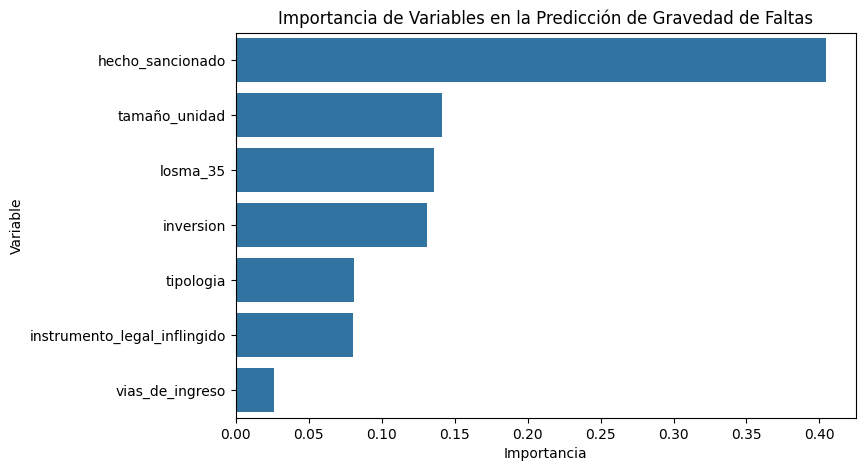

In [66]:
importances = pd.DataFrame({
    "Variable": X.columns,
    "Importancia": model.feature_importances_
}).sort_values(by="Importancia", ascending=False)

print(importances)

# Visualización
plt.figure(figsize=(8,5))
sns.barplot(x="Importancia", y="Variable", data=importances)
plt.title("Importancia de Variables en la Predicción de Gravedad de Faltas")
plt.show()

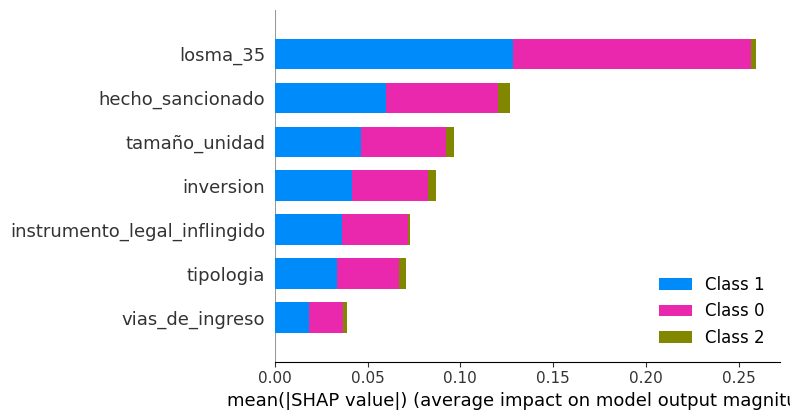

In [67]:
plt.figure(figsize=(8,5))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

# Tarea
Genere una respuesta a la solicitud que incluya las siguientes secciones: "Ejercicio 2", "Cargar los datos", "Explorar los datos", "Preprocesar los datos", "Seleccionar un modelo", "Entrenar el modelo", "Evaluar el modelo", "Determinar la importancia de las variables" y "Considerar modificaciones para identificar fallas graves". Para la sección "Cargar los datos", cargue los datos del archivo "datos_prueba_2.csv" en un DataFrame de Pandas. Para la sección "Ejercicio 2", incluya el texto proporcionado que describe el ejercicio y el esquema de datos. Para las secciones restantes, proporcione un resumen general de los pasos de cada etapa del proceso de aprendizaje automático, adaptado al problema de predicción de la "gravedad_falta".

## Load the data

### Subtask:
Load the data from `datos_prueba_2.csv` into a pandas DataFrame.


**Reasoning**:
The first step is to load the data from the specified CSV file into a pandas DataFrame and display the head to confirm the loading.



In [68]:
df_ejercicio2 = pd.read_csv('/content/datos_prueba_2.csv')
df_ejercicio2.head()

,hecho_sancionado,instrumento_legal_inflingido,losma_35,gravedad_falta,inversion,tipologia,vias_de_ingreso,tamaño_unidad
0,F1: Ausencia de bilbos de geófitas transplanta...,RCA,a,Leves,3.0,N,DIA,2.1
1,"La obtención, con fecha 21 de noviembre de 201...",NE,h,Leves,NaN,NaN,NaN,NaN
2,El lugar en que actualmente se está tomando la...,NE,h,Leves,NaN,NaN,NaN,NaN
3,El establecimiento industrial no reportó la in...,NE,g,Leves,2.0,N,DIA,1.4
4,Realizar actividades de extracción de áridos f...,RCA,a,Leves,NaN,NaN,NaN,NaN


## Explore the data

### Subtask:
Perform exploratory data analysis to understand the data, including checking for missing values, examining the distribution of the target variable `gravedad_falta`, and understanding the types of features.


**Reasoning**:
Perform exploratory data analysis by checking for missing values, displaying data types, examining the distribution of the target variable, and visualizing the distribution.



Missing values per column:


,0
hecho_sancionado,0
instrumento_legal_inflingido,11
losma_35,0
gravedad_falta,29
inversion,1338
tipologia,1417
vias_de_ingreso,1363
tamaño_unidad,1338



Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hecho_sancionado              3000 non-null   object 
 1   instrumento_legal_inflingido  2989 non-null   object 
 2   losma_35                      3000 non-null   object 
 3   gravedad_falta                2971 non-null   object 
 4   inversion                     1662 non-null   float64
 5   tipologia                     1583 non-null   object 
 6   vias_de_ingreso               1637 non-null   object 
 7   tamaño_unidad                 1662 non-null   float64
dtypes: float64(2), object(6)
memory usage: 187.6+ KB

Value counts for 'gravedad_falta':


,count
gravedad_falta,
Leves,2029
Graves,942


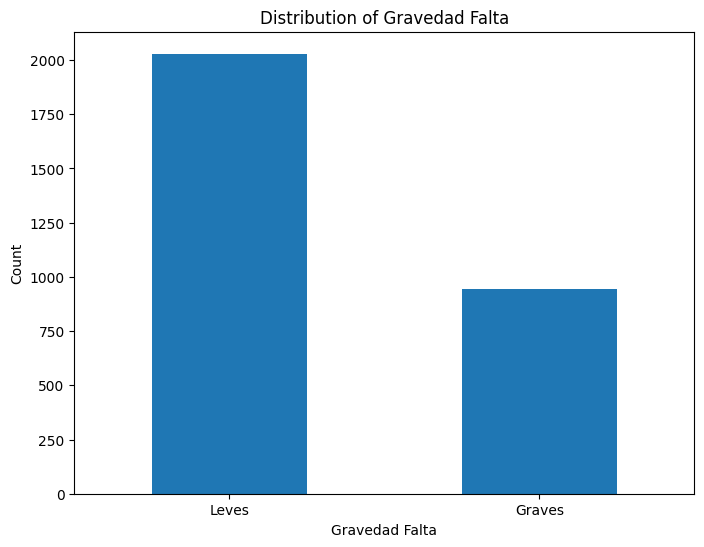

In [69]:
# Check for missing values
print("Missing values per column:")
display(df_ejercicio2.isnull().sum())

# Display data types
print("\nData types:")
df_ejercicio2.info()

# Examine unique values and their counts for the target variable
print("\nValue counts for 'gravedad_falta':")
display(df_ejercicio2['gravedad_falta'].value_counts())

# Visualize the distribution of gravedad_falta
plt.figure(figsize=(8, 6))
df_ejercicio2['gravedad_falta'].value_counts().plot(kind='bar')
plt.title('Distribution of Gravedad Falta')
plt.xlabel('Gravedad Falta')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Preprocess the data

### Subtask:
Handle missing values, encode categorical variables, and potentially scale numerical features.


**Reasoning**:
Handle missing values by dropping rows with missing target variable, impute numerical missing values with the mean and categorical missing values with the mode, encode categorical features using one-hot encoding, scale numerical features using StandardScaler, and then separate features and target variable.



In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Drop rows where the target variable 'gravedad_falta' is missing
df_ejercicio2.dropna(subset=['gravedad_falta'], inplace=True)

# Separate features and target variable
X = df_ejercicio2.drop('gravedad_falta', axis=1)
y = df_ejercicio2['gravedad_falta']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different preprocessing steps to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Display the shape of the processed features
print("Shape of processed features:", X_processed.shape)

Shape of processed features: (2971, 3012)


## Select a model

### Subtask:
Choose an appropriate classification model for predicting the severity of the fault.


**Reasoning**:
Choose a classification model suitable for handling imbalanced datasets and provide a justification for the choice.



In [71]:
from sklearn.ensemble import RandomForestClassifier

# Given the class imbalance observed during exploration,
# a model that can handle imbalanced datasets or where we can apply techniques
# to address imbalance (like class weighting or resampling) is preferable.
# Ensemble methods like Random Forests often perform well on imbalanced data
# and provide insights into feature importance.

# Choose RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)

print("Selected Model: RandomForestClassifier with class_weight='balanced'")

Selected Model: RandomForestClassifier with class_weight='balanced'


## Train the model

### Subtask:
Split the data into training and testing sets and train the selected model.


**Reasoning**:
Split the preprocessed data into training and testing sets and train the selected RandomForestClassifier model.



In [72]:
from sklearn.model_selection import train_test_split

# Split the processed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

# Train the model
model.fit(X_train, y_train)

print("Data split into training and testing sets.")
print("Model trained successfully.")

Data split into training and testing sets.
Model trained successfully.


**Reasoning**:
The model has been trained, now evaluate its performance on the test set.



Classification Report:
              precision    recall  f1-score   support

      Graves       0.56      0.60      0.58       189
       Leves       0.81      0.78      0.79       406

    accuracy                           0.72       595
   macro avg       0.69      0.69      0.69       595
weighted avg       0.73      0.72      0.73       595


Confusion Matrix:
[[114  75]
 [ 89 317]]

AUC: 0.7803


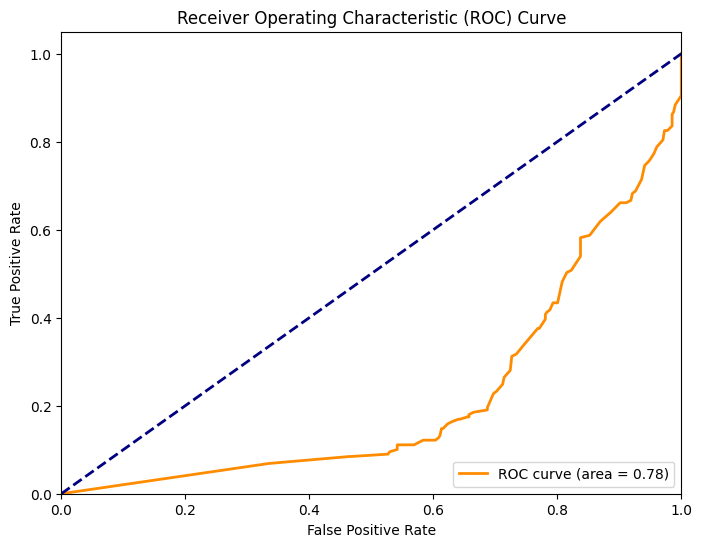

In [73]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class (Graves)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate and print AUC
try:
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC: {auc:.4f}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='Graves')
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

except ValueError as e:
    print(f"\nCould not calculate AUC or plot ROC curve: {e}")
    print("This might happen if the positive class ('Graves') is not present in the test set or if probabilities are not available/meaningful.")


**Reasoning**:
Determine the importance of each variable in the trained model.



Feature Importances:


,0
num__tamaño_unidad,0.064021
num__inversion,0.062455
cat__instrumento_legal_inflingido_NE,0.050842
cat__losma_35_a,0.028463
cat__losma_35_h,0.027216
...,...
"cat__hecho_sancionado_El establecimiento industrial presentó superación de los límites máximos en sus descargas de residuos líquidos a cuerpo de agua fluvial respecto de los contaminantes DBO5, durante los meses de mayo, junio, julio y agosto de 2013, y Coliformes Fecales en los meses de mayo y julio del mismo año.",0.000000
"cat__hecho_sancionado_No haber dado cumplimiento a las normas sobre contenido de los informes de seguimiento ambiental códigos SSA 64355 y 69458 y 56274, específicamente no dar cuenta de la georreferenciación de los puntos de medición, ni los puntos donde se realizó la medición de ruido de fondo, sin indicar la fecha de medición ni horarios y no dando cuenta de la descripción de los equipos de medición utilizados. No haber dado cuenta de la evolución en el tiempo de la variable ambiental, cómo ha sido el comportamiento histórico del proyecto y no dando cuenta de la implementación de medidas adicionales en materia de ruido.",0.000000
"cat__hecho_sancionado_No haber dado respuesta a los siguientes requerimientos de información: a)\tNo haber informado el estado o fase de ejecución del proyecto, mediante la forma y medios instruidos en la Res. Ex. N° 1518, de fecha 26 de diciembre de 2013. b)\tNo entregar la información solicitada en el Acta de Fiscalización Ambiental de fecha 28 de junio de 2017. c)\tNo haber dado respuesta a la información requerida mediante Res. Ex. MZN N° 42/2017.",0.000000
"cat__hecho_sancionado_No haber dado respuesta al requerimiento de información efectuado mediante la Resolución Exenta D.S.C. N° 804, de fecha 6 de julio de 2018, de esta Superintendencia.",0.000000


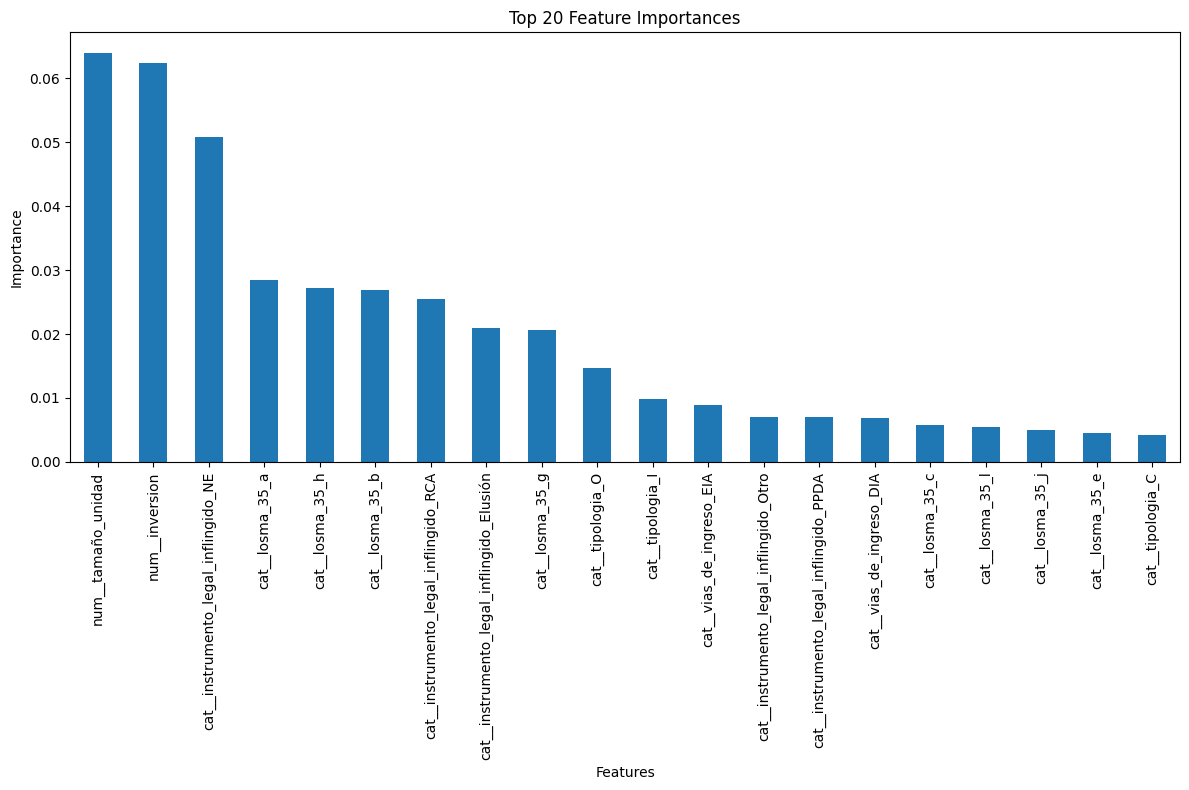

In [74]:
# Determine feature importance
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the trained RandomForestClassifier model
importances = model.feature_importances_

# Create a pandas Series to store feature importances with their names
feature_importances = pd.Series(importances, index=feature_names)

# Sort the feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Print the sorted feature importances
print("Feature Importances:")
display(sorted_feature_importances)

# Plot feature importances (top 20)
plt.figure(figsize=(12, 8))
sorted_feature_importances.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Ejercicio 3

Considerando la introducción anterior, responda los siguientes puntos:

#### Introducción
Como consultora ambiental buscamos desarrollar un `asesor` o `agente` ambiental, el cual permita mejorar la calidad y velocidad de la consultoría ambiental.
Dentro de este desafío encontramos diferentes documentos y diferentes jerarquías que los unen. A modo de ejemplo del proceso, la gestión ambiental se compone de los siguientes pasos (cada paso posee documentos exclusivos):
- Previa evaluación (Saber si debe o no entrar al sistema de evaluación ambiental)
- Evaluación ambiental
- Preguntas y aclaraciones de la autoridad (Proceso iterativo)
- Modificación del proyecto (En caso de ser necesario)
- Aprobación del proyecto
- Acciones que debe realizar
- En caso de cometer faltas, existen procesos sancionatorios.
- En caso de que el proceso evolucione pueden surgir demandas.

- Cree un `mapa conceptual` de la elaboración de un agente que permita resolver consultas, detalle los `pasos` y `frameworks` potenciales por actividad.
- De acuerdo al flujo creado, detalle en que puntos se pueden proponer mejoras respecto de los frameworks ya existentes.
- Asocie una cantidad de tiempo e importancia a cada punto del flujo, indique en que actividad pondría mayor énfasis.
- Si la cantidad de documentos varía desde 100, 1.000, 10.000 hasta 10.000.000, que efectos pueden acentuarse en su sistema? Detalle.